In [3]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random
import matplotlib.pyplot as plt

In [4]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    print("Stats")
    print(TP,FP,TN,FN)

    print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    print("TPR: {}".format(TPR))
    print("TNR: {}".format(TNR))
    print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER

### Split Training Dataset into Train and Validation Datasets

In [5]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating,1])

random.shuffle(dataset)

X = [values[0:3] for values in dataset]
y = [values[-1] for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


In [60]:
dataset[0]

['u92860617', 'b49351989', '5', 1]

In [7]:
yvalid[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
bookCount = defaultdict(int)
readerCount = defaultdict(int)
totalRead = 0

# Count the num of times a book is read, and aggregate the total num of reads
for user,book,_ in readCSV("assignment1/train_Interactions.csv"):
  bookCount[book] += 1
  readerCount[user] += 1
  totalRead += 1

print("Total num of books: {}".format(len(bookCount)))    
print("Total num of readers: {}".format(len(readerCount))) 
print("Total num of reads: {}".format(totalRead))

# Generate a list of book_id and times_read in descending popularity
mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

# Generate a list of user_id and books_read in descending popularity
mostWellRead = [(readerCount[x], x) for x in readerCount]
mostWellRead.sort()
mostWellRead.reverse()

Total num of books: 7170
Total num of readers: 11357
Total num of reads: 200000


### Generate lists and sets for Similarity Calculations

#### Jaccard Similarity between Books

Jsim(i,j) = Intersection(U_i, U_j)/ Union(U_i, U_j)  

where U_i, U_j are set of readers who have read book i and book j  

#### Pearson Similarity between Books


Psim(i,j) = Sum_Product_crij((R_u_i-AR_u), (R_u_j-AR_u))/ SqRt(Sum_crij(Sq(R_u_i-AR_u)))SqRt(Sum_crij(Sq(R_u_j-AR_u)))  

where 
* crij - the set of readers who have read both book i and j  
* R_u_i = Rating that reader u gives book i  
* AR_u = Average rating given by reader u  





In [8]:
user_Books_full = defaultdict(set)  # Set of (user, books_read)
user_Books_Ratings_full = defaultdict(set)  # Set of (user, set(book_read, rating))
book_Readers_full = defaultdict(set)  # Set of (book, readers)
book_ids=[]

for user,book,rating in X:
  user_Books_full[user].add(book)
  user_Books_Ratings_full[user].add((book,rating))
  book_Readers_full[book].add(user)
  if book not in book_ids:
        book_ids.append(book)

In [9]:
len(user_Books_full),len(user_Books_Ratings_full),len(book_Readers_full), len(book_ids)

(11357, 11357, 7170, 7170)

In [10]:
user_Books_train = defaultdict(set)
user_Books_Ratings_train = defaultdict(set)
book_Readers_train = defaultdict(set)
book_Ratings_train = defaultdict(set)

for user,book,rating in Xtrain:
  user_Books_train[user].add(book)
  user_Books_Ratings_train[user].add((book,rating))
  book_Readers_train[book].add(user)
  book_Ratings_train[book].add(rating)


In [11]:
len(user_Books_train),len(user_Books_Ratings_train),len(book_Readers_train),len(book_Ratings_train)

(11357, 11357, 7170, 7170)

In [12]:
print ("Books read by user:")
i = 0
for value in user_Books_train:
    i += 1
    if i > 3:
        break
    print (value, user_Books_train[value])
    
print ("Books and Ratings by user:")
i = 0
for value in user_Books_Ratings_train:
    i += 1
    if i > 3:
        break
    for book, rating in user_Books_Ratings_train[value]:
        print(value, book, rating)

print ("Readers of book:")
i = 0
for value in book_Readers_train:
    i += 1
    if i > 3:
        break
    print (value, book_Readers_train[value])


Books read by user:
u92860617 {'b14149814', 'b10666766', 'b76818420', 'b65490699', 'b49351989', 'b12292730', 'b72600319', 'b14154147', 'b08270813', 'b88970616', 'b14534905', 'b45789004', 'b28154053', 'b73465859'}
u32396276 {'b59474527', 'b74382968', 'b47715156', 'b85011129', 'b33452085', 'b90262618', 'b30848216', 'b59875953', 'b57813406', 'b96712865', 'b46190346', 'b09925221', 'b02298658', 'b11544830', 'b82374557', 'b69000470', 'b54843135', 'b00989537', 'b34889122', 'b61189181', 'b29181017', 'b76389452', 'b17700065', 'b92812801', 'b30178176', 'b28776102', 'b12503442', 'b66352499', 'b25228847', 'b89338766', 'b40689362', 'b93849292', 'b28550617', 'b24746202', 'b85126302', 'b88697698', 'b02293155', 'b92838791', 'b28947111', 'b95498075', 'b70011719', 'b92725558', 'b16755175', 'b23178965', 'b66937334', 'b09588767', 'b57692646', 'b12292730', 'b43247600', 'b81698526', 'b66968346', 'b11403370', 'b92733205', 'b80488508', 'b07334075'}
u93705814 {'b88633275', 'b09661260', 'b08515491', 'b28889278'

### Create a validation dataset of alternating read and unread books per user

In [13]:
def unread_book(user, read_books):
    # Find a random unread book for a specific user
    
    book = random.choice(book_ids)  # pick a book from full library
    while book in read_books:
        book = random.choice(book_ids)
    return book

In [66]:
Xvalid_full = []
yvalid_full = []

for value in zip(Xvalid,yvalid):
    x,read = value
    user = x[0]
    book = x[1]
    Xvalid_full.append([user, book])
    yvalid_full.append(read)
    
    book = unread_book(user, user_Books_full[user])
    Xvalid_full.append([user, book])
    yvalid_full.append(0)
    
Xtrain_full = []
ytrain_full = []

for value in zip(Xtrain,ytrain):
    x,read = value
    user = x[0]
    book = x[1]
    Xtrain_full.append([user, book])
    ytrain_full.append(read)
    
    book = unread_book(user, user_Books_full[user])
    Xtrain_full.append([user, book])
    ytrain_full.append(0)

## (1) Popularity Threshold at 65%, Accuracy=0.664

In [17]:
popularity = [0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9]

for popular in popularity:
    
    # Generate popular book set
    popular_books = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      popular_books.add(i)
      if count > totalRead * popular: 
        break
    
    # Generate prediction
    pred_valid = []
    for user,book in Xvalid_full:
        if book in popular_books:
            pred_valid.append(1)
        else:
            pred_valid.append(0)
            
    correct_pred = numpy.equal(pred_valid,yvalid_full)
    accuracy = sum(correct_pred)/len(correct_pred)
    print("Accuracy at {}% popularity: {}".format(int(popular*100),accuracy))

Accuracy at 10% popularity: 0.5436543654365437
Accuracy at 20% popularity: 0.5817581758175817
Accuracy at 30% popularity: 0.6113111311131113
Accuracy at 40% popularity: 0.6407140714071408
Accuracy at 50% popularity: 0.6538153815381538
Accuracy at 55% popularity: 0.659015901590159
Accuracy at 60% popularity: 0.6607660766076607
Accuracy at 65% popularity: 0.6597659765976598
Accuracy at 70% popularity: 0.6535153515351535
Accuracy at 80% popularity: 0.6322132213221322
Accuracy at 90% popularity: 0.5923592359235924


## Best Popularity Model


In [18]:
popularity = [0.60]

for popular in popularity:
    
    # Generate popular book set
    popular_books = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      popular_books.add(i)
      if count > totalRead * popular: 
        break
    
    # Generate prediction
    pred_valid = []
    for user,book in Xvalid_full:
        if book in popular_books:
            pred_valid.append(1)
        else:
            pred_valid.append(0)

### Baseline Model --> High FP and FN

The Baseline Model based on Popularity evenly predicts P and N. But TPR and TNR are only 60% and 72%.

In [19]:
print("Validation Error Stats")
calc_model_stats(pred_valid,yvalid_full)

Validation Error Stats
Stats
6022 2807 7192 3977
Predict N: 11169 (0.5585058505850585%)
Predict P: 8829 (0.4414941494149415%)
Accuracy: 0.6607660766076607
TPR: 0.6022602260226022
TNR: 0.7192719271927193
BER: 0.33923392339233926


In [21]:
def list_pad(l, n):
    # if len(l) > n, the method truncates the list l to length n 
    # if n > len(l), the method pads list l with zero up to length n 
    return l[:n] + [0]*(n-len(l))

"""
Jaccard Similarity
"""

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

"""
When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def items_jsim(book1, book2):
    # generate readers set for the 2 books based on train dataset
    s1 = book_Readers_train[book1]
    s2 = book_Readers_train[book2]
    return Jaccard(s1, s2)

def users_jsim(reader1, reader2):
    # generate Books set for the 2 readers based on train dataset
    s1 = user_Books_train[reader1]
    s2 = user_Books_train[reader2]
    return Jaccard(s1, s2)

def jsim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to book b
    # and return Jaccard(b, book) in descending order
    jsims = []
    
    # Go through the books read by reader r
    for other_book in user_Books_train[r]:
        if b == other_book: 
           continue   # skip if the book is b
        jsim = items_jsim(b, other_book)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  

def jsim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Jaccard(r, reader) in descending order
    jsims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        jsim = users_jsim(r, reader)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  


def user_jaccard_predict(user, book, threshold):
    
    user_jsims = jsim_mostSimilar_users(book,user)
    if len(user_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = user_jsims[0]
        
    if max_jsim > threshold:
        predict = True
    else:
        predict = False
    return predict, max_jsim

def book_jaccard_predict(user, book, threshold):
    
    book_jsims = jsim_mostSimilar_items(user,book)
    if len(book_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = book_jsims[0]
        
    if max_jsim > threshold:
        predict = True
    else:
        predict = False
    return predict, max_jsim


In [22]:
jsim_mostSimilar_items('u80908575', 'b72504285')

[0.04,
 0.03333333333333333,
 0.03225806451612903,
 0.03125,
 0.03125,
 0.02702702702702703,
 0.02702702702702703,
 0.02702702702702703,
 0.02564102564102564,
 0.02127659574468085,
 0.02040816326530612,
 0.017241379310344827,
 0.011627906976744186,
 0.011235955056179775,
 0.011111111111111112,
 0.009433962264150943,
 0.007633587786259542]

In [23]:
jsim_mostSimilar_users('b72504285','u80908575')

[0.038461538461538464,
 0.037037037037037035,
 0.03571428571428571,
 0.034482758620689655,
 0.034482758620689655,
 0.03333333333333333,
 0.03333333333333333,
 0.03225806451612903,
 0.03125,
 0.030303030303030304,
 0.030303030303030304,
 0.02702702702702703,
 0.02702702702702703,
 0.024390243902439025,
 0.023255813953488372,
 0.022222222222222223,
 0.0196078431372549,
 0.015625]

## (2) User Jaccard Similarity Threshold @ 0.03, Accuracy=0.643

When Jaccard threshold is too high, the model predicts False all the time, so accuracy is 0.5 since the validation labels at 50-50 True-False.

The optimal threshold is around 0.01, whereby accuracy peaks at 0.625.

Accuracy falls as threshold approaches zero. At threshold=0, the model only predicts False when the readers set of the book is completely disjoint from the readers sets of all the books read by the user.

In [25]:
thresholds = [1.0, 0.25, 0.10, 0.05, 0.04, 0.03, 0.025, 0.02, 0.01, 0]

for threshold in thresholds:
    # Generate prediction
    pred_valid = []

    for value in Xvalid_full:
        user, book = value
        predict, max_jsim = user_jaccard_predict(user,book,threshold)
        pred_valid.append(predict)    
        
    correct_pred = numpy.equal(pred_valid,yvalid_full)
    accuracy = sum(correct_pred)/len(correct_pred)
    print("Accuracy at threshold={}: {}".format(threshold,accuracy))

Accuracy at threshold=1.0: 0.5
Accuracy at threshold=0.25: 0.5
Accuracy at threshold=0.1: 0.502050205020502
Accuracy at threshold=0.05: 0.5616561656165616
Accuracy at threshold=0.04: 0.6081608160816082
Accuracy at threshold=0.03: 0.6426142614261426
Accuracy at threshold=0.025: 0.6416141614161416
Accuracy at threshold=0.02: 0.6259625962596259
Accuracy at threshold=0.01: 0.5894089408940895
Accuracy at threshold=0: 0.587958795879588


In [26]:
threshold = 0.03
# Generate prediction
pred_valid = []

for value in Xvalid_full:
    user, book = value
    predict, max_jsim = user_jaccard_predict(user,book,threshold)
    # print (user,book,predict, max_jsim)
    pred_valid.append(predict) 

### User_Jaccard Model --> Lower False-Negatives

The Jaccard Model overpredicts Positive, resulting in high FP.

In [27]:
print("Validation Error Stats")
calc_model_stats(pred_valid,yvalid_full)

Validation Error Stats
Stats
6255 3403 6596 3744
Predict N: 10340 (0.517051705170517%)
Predict P: 9658 (0.4829482948294829%)
Accuracy: 0.6426142614261426
TPR: 0.6255625562556255
TNR: 0.6596659665966597
BER: 0.35738573857385747


In [30]:
thresholds = [1.0, 0.10, 0.05, 0.02, 0.01, 0.005, 0]

for threshold in thresholds:
    # Generate prediction
    pred_valid = []

    for value in Xvalid_full:
        user, book = value
        predict, max_jsim = book_jaccard_predict(user,book,threshold)
        pred_valid.append(predict)    
        
    correct_pred = numpy.equal(pred_valid,yvalid_full)
    accuracy = sum(correct_pred)/len(correct_pred)
    print("Accuracy at threshold={}: {}".format(threshold,accuracy))

Accuracy at threshold=1.0: 0.5
Accuracy at threshold=0.1: 0.5002000200020001
Accuracy at threshold=0.05: 0.504000400040004
Accuracy at threshold=0.02: 0.5659065906590659
Accuracy at threshold=0.01: 0.618011801180118
Accuracy at threshold=0.005: 0.5957595759575958
Accuracy at threshold=0: 0.587958795879588


In [31]:
threshold = 0.01
# Generate prediction
pred_valid = []

for value in Xvalid_full:
    user, book = value
    predict, max_jsim = book_jaccard_predict(user,book,threshold)
    # print (user,book,predict, max_jsim)
    pred_valid.append(predict) 

print("Validation Error Stats")
calc_model_stats(pred_valid,yvalid_full)

Validation Error Stats
Stats
8130 5770 4229 1869
Predict N: 6098 (0.3049304930493049%)
Predict P: 13900 (0.695069506950695%)
Accuracy: 0.618011801180118
TPR: 0.813081308130813
TNR: 0.4229422942294229
BER: 0.381988198819882


## (3) Ensemble Popularity, Book and User Jaccard Similarity

Two approaches are used:

1. If book is popular, predict read. If book is not popular, use Jaccard Similarity to predict read.
Accuracy = 0.62

2. If book is popular and Jaccard Similarity > 0.01, predict read. Otherwise, predict zero.
Accuracy = 0.673



In [58]:
popularity_thresholds = [0.65]
user_jaccard_threshold = 0.025
book_jaccard_threshold = 0.008

for popular in popularity_thresholds:
    
    # Generate popular book set
    popular_books = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      popular_books.add(i)
      if count > totalRead * popular: 
        break
    
    # Generate +ve prediction when book is popular OR is similar
    pred_valid = []
    for user,book in Xvalid_full:
        # Predict using Jaccard similarity
        similar_users, user_max_jsim = user_jaccard_predict(user,book,user_jaccard_threshold)
        similar_books, book_max_jsim = book_jaccard_predict(user,book,book_jaccard_threshold)
        
        popular_book = book in popular_books
        
        if (popular_book and similar_users) or (popular_book and similar_books):
            pred_valid.append(1)
        elif user_max_jsim > 0.05 or book_max_jsim > 0.045:
            pred_valid.append(1)
        else:  
            pred_valid.append(0)

In [59]:
print("Validation Error Stats")
calc_model_stats(pred_valid,yvalid_full)

Validation Error Stats
Stats
6743 3324 6675 3256
Predict N: 9931 (0.4965996599659966%)
Predict P: 10067 (0.5034003400340034%)
Accuracy: 0.6709670967096709
TPR: 0.6743674367436744
TNR: 0.6675667566756676
BER: 0.32903290329032897


In [43]:
popularity_thresholds = [0.60]
user_jaccard_threshold = 0.03
book_jaccard_threshold = 0.01

for popular in popularity_thresholds:
    
    # Generate popular book set
    popular_books = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      popular_books.add(i)
      if count > totalRead * popular: 
        break
    
    # Generate +ve prediction when book is popular OR is similar
    pred_valid = []
    for user,book in Xvalid_full:
        # Predict using Jaccard similarity
        user_jsim_predict, max_jsim = user_jaccard_predict(user,book,user_jaccard_threshold)
        book_jsim_predict, max_jsim = book_jaccard_predict(user,book,book_jaccard_threshold)
        
            pred_valid.append(1)
        elif user_jsim_predict and book_jsim_predict:
            pred_valid.append(1)
        else:  
            pred_valid.append(0)


In [44]:
print("Validation Error Stats")
calc_model_stats(pred_valid,yvalid_full)

Validation Error Stats
Stats
5653 2744 7255 4346
Predict N: 11601 (0.5801080108010801%)
Predict P: 8397 (0.4198919891989199%)
Accuracy: 0.6454645464546455
TPR: 0.5653565356535654
TNR: 0.7255725572557256
BER: 0.35453545354535454


## Kaggle Submission, Accuracy=0.68, User_Name='Luke Liem'

This result is based on optimizing popularity and Jaccard thresholds using hyperparameter search.

Essentially the model predicts that a user will read a book (P) if:

* the book is popular AND it is similar to the other books read by the user
* the book is very very similar to the other books read by the user.

In [290]:
popularity_threshold = 0.650
jaccard_threshold = 0.008
very_similar_threshold = 0.045

# Generate popular book set
popular_books = set()
count = 0
for ic, i in mostPopular:
    count += ic
    popular_books.add(i)
    if count > totalRead * popularity_threshold: 
        break

predictions = open("assignment1/predictions_Read.txt", 'w')
for l in open("assignment1/pairs_Read.txt"):

    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    
    user,book = l.strip().split('-')

    # Predict using Jaccard similarity

    jsim_predict, max_jsim = jaccard_predict(user,book,jaccard_threshold)
    
    similar = jsim_predict
    popularbook = book in popular_books
    
    if popularbook and similar:
        predictions.write(user + '-' + book + ",1\n")
    elif max_jsim > very_similar_threshold:
        predictions.write(user + '-' + book + ",1\n") 
    else:  
        predictions.write(user + '-' + book + ",0\n")

predictions.close()

## (4) Logistic Regression Model - Popularity Only

Start simple:

X.theta = y

where X = [popularity], popularity= (times a book is read)/(total num of reads)

Accuracy = 0.65

In [123]:
len(Xvalid_full)

19998

In [71]:
Xtrain_full[:10]

[['u19508046', 'b58516196'],
 ['u14337391', 'b70852919'],
 ['u51044012', 'b87887241'],
 ['u72647231', 'b08218205'],
 ['u76903642', 'b83219157'],
 ['u98136734', 'b80466863'],
 ['u91675942', 'b07530537'],
 ['u68997607', 'b63964479'],
 ['u26968875', 'b96347205'],
 ['u47039508', 'b33382845']]

In [72]:
ytrain_full[:10]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0]

In [128]:
# X_train = [[1,bookCount[b]/totalRead,readerCount[u]/totalRead] for u,b in Xtrain_full]
X_train = [[1,bookCount[b]/totalRead] for u,b in Xtrain_full]

y_train = ytrain_full

# X_valid = [[1,bookCount[b]/totalRead,readerCount[u]/totalRead] for u,b in Xvalid_full]
X_valid = [[1,bookCount[b]/totalRead] for u,b in Xvalid_full]
y_valid = yvalid_full

print(X_train[:10])

[[1, 0.00041], [1, 4.5e-05], [1, 0.000235], [1, 5e-05], [1, 0.000445], [1, 8e-05], [1, 0.000275], [1, 8.5e-05], [1, 0.00131], [1, 0.0001]]


## Dataset Characterization

Total num of books: 7170
Total num of readers: 11357
Total num of reads: 200000

<function matplotlib.pyplot.show>

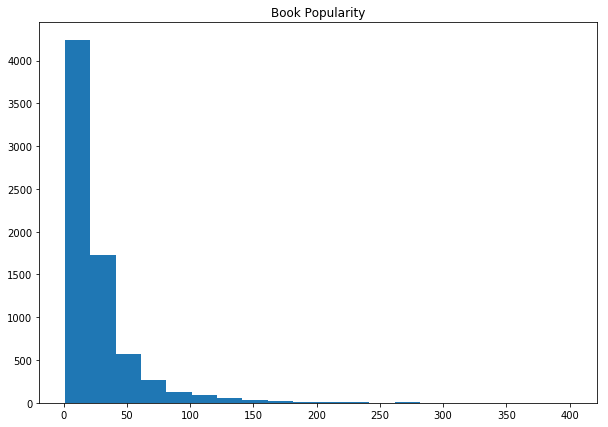

In [114]:
book_popularity=numpy.array(numpy.array(mostPopular).T[0],dtype=int)
plt.figure(figsize=(10,7))
plt.title("Book Popularity")
plt.hist(book_popularity, bins=20)
plt.show


<function matplotlib.pyplot.show>

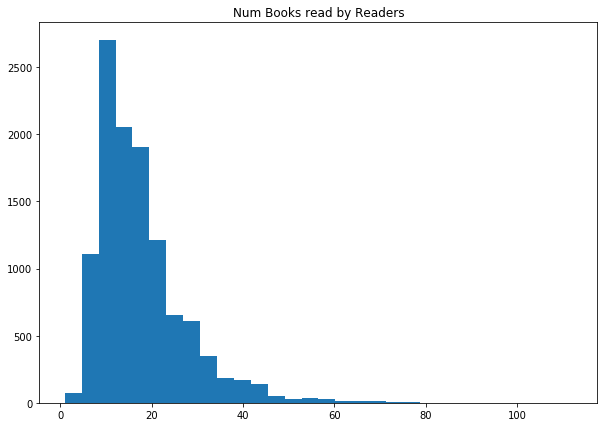

In [115]:
well_read=numpy.array(numpy.array(mostWellRead).T[0],dtype=int)
plt.figure(figsize=(10,7))
plt.title("Num Books read by Readers")
plt.hist(well_read, bins=30)
plt.show


In [129]:
model = linear_model.LogisticRegression(C=1.0)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

print("Training Error Stats")
calc_model_stats(train_pred,y_train)

print("Validation Error Stats")
calc_model_stats(valid_pred,y_valid)


/home/lukeliem/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Error Stats
Stats
86231 30701 159300 103770
Predict N: 263070 (0.6922858300745786%)
Predict P: 116932 (0.30771416992542144%)
Accuracy: 0.646130809837843
TPR: 0.4538449797632644
TNR: 0.8384166399124215
BER: 0.353869190162157
Validation Error Stats
Stats
4563 1630 8369 5436
Predict N: 13805 (0.6903190319031903%)
Predict P: 6193 (0.3096809680968097%)
Accuracy: 0.6466646664666467
TPR: 0.45634563456345634
TNR: 0.836983698369837
BER: 0.35333533353335334


In [7]:
mostWellRead

[(112, 'u11591742'),
 (110, 'u28921939'),
 (106, 'u39338306'),
 (98, 'u51185462'),
 (87, 'u26190516'),
 (80, 'u45829657'),
 (79, 'u92864068'),
 (78, 'u60718036'),
 (77, 'u99307189'),
 (77, 'u70099782'),
 (76, 'u79690854'),
 (76, 'u17375521'),
 (73, 'u64015490'),
 (73, 'u20280784'),
 (73, 'u18599916'),
 (72, 'u93744132'),
 (72, 'u36412412'),
 (71, 'u53724739'),
 (70, 'u95352987'),
 (70, 'u21268188'),
 (70, 'u19562368'),
 (69, 'u76635539'),
 (69, 'u59138372'),
 (68, 'u91675942'),
 (68, 'u79624766'),
 (68, 'u63006686'),
 (68, 'u35569205'),
 (67, 'u49458087'),
 (67, 'u01715325'),
 (66, 'u72180559'),
 (66, 'u69340764'),
 (66, 'u50379803'),
 (66, 'u48159222'),
 (66, 'u43983953'),
 (66, 'u38243503'),
 (66, 'u30700501'),
 (65, 'u93289879'),
 (65, 'u67394330'),
 (65, 'u42592659'),
 (65, 'u32714980'),
 (65, 'u28165225'),
 (64, 'u60460119'),
 (64, 'u40949227'),
 (64, 'u39575746'),
 (63, 'u88395157'),
 (63, 'u61645614'),
 (63, 'u03883509'),
 (63, 'u00405736'),
 (62, 'u05582292'),
 (61, 'u81539151'

In [8]:
mostPopular

[(402, 'b25543219'),
 (333, 'b21517939'),
 (331, 'b76915592'),
 (285, 'b55315814'),
 (280, 'b02830492'),
 (279, 'b75885962'),
 (274, 'b52453648'),
 (264, 'b25118404'),
 (262, 'b39244888'),
 (249, 'b87250311'),
 (248, 'b75743714'),
 (241, 'b72194541'),
 (239, 'b11544830'),
 (235, 'b70343057'),
 (232, 'b84299066'),
 (224, 'b65684502'),
 (219, 'b75776178'),
 (219, 'b59273300'),
 (218, 'b96347205'),
 (216, 'b30737799'),
 (215, 'b14913608'),
 (209, 'b00434263'),
 (206, 'b28542052'),
 (197, 'b41598050'),
 (197, 'b22593148'),
 (193, 'b93502799'),
 (192, 'b98923466'),
 (192, 'b33376751'),
 (191, 'b65149363'),
 (189, 'b82138212'),
 (188, 'b50640872'),
 (185, 'b92932322'),
 (184, 'b80820222'),
 (184, 'b70952603'),
 (181, 'b89076881'),
 (181, 'b10036624'),
 (179, 'b05351352'),
 (178, 'b46514894'),
 (175, 'b86626886'),
 (174, 'b38067574'),
 (172, 'b43966591'),
 (171, 'b65584610'),
 (171, 'b25704142'),
 (171, 'b24178664'),
 (170, 'b05810373'),
 (168, 'b97884773'),
 (168, 'b88269686'),
 (168, 'b0746